# Evaluation Similarity Prediction Measures

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import numpy as np
import scipy.spatial
import re

import os.path
import glob
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from gensim import corpora
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split

from sklearn.tree import export_graphviz
import graphviz
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

import warnings
warnings.filterwarnings('ignore')

/home/phuong/.local/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


## Data preparation
1. Remove ASNI color codes
2. Remove non-letter characters (including numbers and punctuation)
3. Remove one-letter words
4. Convert all to lower case
5. Stem to the base form (optional)

In [2]:
def data_preparation(log):
    num_lines = log.count('\n')+1
    log = re.sub('\\x1b\\[[0-9;]*m',' ', log) # ANSI color codes
    log = re.sub('[^a-zA-Z ]',' ', log) # non-letter characters
    log = re.sub('\\b[\\w]{1}\\b',' ', log) # one-letter words
    log = log.lower() # convert to lower case
    log = ' '.join(log.split()) # create a string of words split by 1 space
    log = log.split(' ')
    return log, num_lines

In [3]:
df = pd.DataFrame()  ## list of log files with type
allfiles = glob.glob('./logs/*')
for logfile in allfiles:
    f = open(logfile, 'r')
    filename = os.path.basename(logfile)
    content, num_lines = data_preparation(f.read())
    words = len(content)
    filesize = os.path.getsize(logfile)
    data = [filename, content, words, num_lines, filesize, filename.split('_')[0]]
    log = pd.DataFrame([data], columns=['filename', 'data', '#words', '#lines', 'size (bytes)', 'type'])
    df = df.append(log, ignore_index=True)

In [4]:
set(df['type'])

{'backend', 'db', 'deployment', 'frontend'}

In [5]:
df

,filename,data,#words,#lines,size (bytes),type
0,db_mysql.log,"[mysql, note, entrypoint, entrypoint, script, ...",884,76,10336,db
1,deployment_elasticsearch.txt,"[sudo, kolla, set, configs, info, main, loadin...",161,25,2060,deployment
2,deployment_mariadb.txt,"[sudo, kolla, set, configs, info, main, loadin...",1413,136,13294,deployment
3,db_user-db.log,"[control, initandlisten, mongodb, starting, pi...",230,25,2788,db
4,deployment_prometheus.txt,"[sudo, kolla, set, configs, info, main, loadin...",475,41,5325,deployment
5,db_orders-db.log,"[control, initandlisten, mongodb, starting, pi...",227,26,2914,db
6,db_carts-db.log,"[control, initandlisten, mongodb, starting, pi...",230,26,2915,db
7,frontend_kibana.log,"[type, log, timestamp, tags, info, plugins, se...",392,16,4660,frontend
8,frontend_horizon.log,"[wed, jun, wsgi, error, pid, tid, usr, lib, py...",437,20,4197,frontend
9,backend_queue-master.log,"[spring, boot, release, info, main, queuemaste...",1466,45,16675,backend


In [6]:
def names_logs(df):
     return df['filename'].tolist(), df['data'].tolist()

# Similarity Measures

Further preprocessing step: Stemmed nouns and verbs to base form

In [7]:
def lemma_set(df):
    ps = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    tagged_logs = [nltk.pos_tag(log) for log in df['data'].to_list()]
    stemmed_logs = []
    for tagged_log in tagged_logs:
        stemmed_log = list(filter(lambda x: x[1].startswith('N') or x[1].startswith('V'), tagged_log))
        #print([(pair[0], pair[1][0].lower()) for pair in stemmed_log])
        stemmed_logs.append([lemmatizer.lemmatize(pair[0], pos=pair[1][0].lower()) for pair in stemmed_log])
    set_logs = [set(log) for log in stemmed_logs]
    #ordered_set_logs = [list(dict.fromkeys(log)) for log in stemmed_logs]
    return df['filename'].to_list(), set_logs

## LSI-based Jaccard Similarity
Input: A set of stemmed nouns and verbs

### Latent Semantic Indexing

In [8]:
def prepare_corpus(files):
    # Creating the term dictionary of our corpus, where every unique term is assigned an index
    dictionary = corpora.Dictionary(files)
    #dictionary.add_documents(files) # Update dictionary with new file
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in files]
    # generate LDA model
    return dictionary,doc_term_matrix

def lsi(filenames, files, num_topics, num_keywords):
    dictionary,doc_term_matrix = prepare_corpus(files)
    # generate LSI model
    lsimodel = LsiModel(doc_term_matrix, num_topics=num_topics, id2word=dictionary)  # train model
    #model.add_documents(files)  # update model with new documents
    topics = lsimodel.show_topics(num_topics=num_topics, num_words=num_keywords, formatted=False)
    topics = topics
    print("-----------TOPIC - KEYWORDS--------------")
    print(topics)    
    
    V = lsimodel[doc_term_matrix]
    print("\n-----------TOPIC - DOCUMENT--------------")
    topic_log = list(zip(V, filenames))
    print(topic_log)
    #topic_doc = []
    #for doc, as_text in zip(V, filenames):
        #topic_doc.append((doc, as_text))
        #print(doc, as_text)
    return topics, topic_log

    # The sign is not important, although it keeps flipping from run to run

### LSI-based Jaccard Similarity

In [9]:
def lsi_jaccard_similarity(new_log, old_log, keywords):
    common_words = new_log.intersection(old_log)
    total_words = new_log.union(old_log)
    common = len(common_words)
    total = len(total_words)
    for word in common_words:
        for keyword in keywords:
            if word == keyword[0]:
                common += 1 + abs(keyword[1])
                total += 1 + abs(keyword[1])
    return common/total

def lsi_jaccard_ranker(requested_df, old_dfs):
    num_topics = 1  # number of topics
    num_keywords = 20   # number of generated keywords
    name, requested_log = lemma_set(requested_df)
    names, old_logs = lemma_set(old_dfs)
    topics, V = lsi(names, old_logs, num_topics, num_keywords)
    keywords = topics[0][1]
    ranking = []
    for old_log in old_logs:
        value = lsi_jaccard_similarity(requested_log[0], old_log, keywords)
        ranking.append((names[old_logs.index(old_log)], value))
    ranking.sort(key=lambda pair: pair[1], reverse=True)
    return ranking, keywords

## TF-IDF Cosine Similarity

In [10]:
def tfidf_similarity(file1, file2):
    vectorizer = TfidfVectorizer(tokenizer=lambda x:x, preprocessor=lambda x:x)
    # Generate matrix of word vectors
    tfidf_matrix = vectorizer.fit_transform([file1, file2])
    cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
    return cosine_sim[0][1]

def tfidf_ranker(requested_df, old_dfs):
    name, requested_log = names_logs(requested_df)
    names, old_logs = names_logs(old_dfs)
    ranking = []
    for old_log in old_logs:
        value = tfidf_similarity(requested_log[0], old_log)
        ranking.append((names[old_logs.index(old_log)], value))
    ranking.sort(key=lambda pair: pair[1], reverse=True)
    return ranking

## GloVe Cosine Similarity

In [11]:
def loadGloveModel(gloveFile):
    print ("Loading Glove Model")
    with open(gloveFile, encoding="utf8" ) as f:
        content = f.readlines()
    model = {}
    for line in content:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print ("Done.",len(model)," words loaded!")
    return model

def glove_similarity(model, file1, file2):
    vector_1 = np.mean([model.get(word, np.zeros(50)) for word in file1],axis=0)
    vector_2 = np.mean([model.get(word, np.zeros(50)) for word in file2],axis=0)
    cosine = scipy.spatial.distance.cosine(vector_1, vector_2)
    return abs(1-cosine)

def glove_ranker(requested_df, old_dfs):
    name, requested_log = names_logs(requested_df)
    names, old_logs = names_logs(old_dfs)
    # Write corpus for GloVe training
    flattened_logs = [y for x in requested_log+old_logs for y in x]
    corpus = ' '.join(flattened_logs)
    with open('GloVe/corpus.txt', 'w') as f:
        f.write(corpus)
    os.system('cd GloVe/ ; ./glove.sh corpus.txt')
    gloveFile = "GloVe/vectors.txt"
    model = loadGloveModel(gloveFile)
    
    ranking = []
    for old_log in old_logs:
        value = glove_similarity(model, requested_log[0], old_log)
        ranking.append((names[old_logs.index(old_log)], value))
    ranking.sort(key=lambda pair: pair[1], reverse=True)
    
    os.remove('GloVe/vectors.bin')
    os.remove('GloVe/vectors.txt')
    return ranking

# Classifiers

## LSI-based Classifier

In [12]:
def lsi_classifier(df, num_topics):
    names, logs = names_logs(df)
    num_keywords=20
    topics, topics_logs = lsi(names, logs, num_topics, num_keywords)
    max_log = []
    for topic_log in topics_logs:
        name = topic_log[1]
        topic_weights = topic_log[0]
        topic_weights.sort(key=lambda pair: abs(pair[1]), reverse=True)
        max_topic = topic_weights[0]
        max_log.append(max_topic[0])
    return max_log

## Naive Bayes Classifier and Decision Tree Classifier

In [13]:
def report(classifier, actual, predictions):
    print(classifier)
    actual = np.array(actual)
    print(classification_report(actual, predictions))
    print("Accuracy: " + str(round(accuracy_score(actual, predictions),2)))
    
def classify(df, algorithm, init_state):
    X_train, X_test, y_train, y_test = train_test_split(df['data'], df['type'], test_size=0.2, random_state=init_state)
    #train
    model = Pipeline([('tfidf', TfidfVectorizer(tokenizer=lambda x:x, preprocessor=lambda x:x)), ('clf', algorithm)])
    model.fit(X_train, y_train)
    #test
    predictions = model.predict(X_test.sort_index())
    test_result = df[df.index.isin(X_test.index)]
    test_result[(str(algorithm).split('(')[0])] = predictions
    report((str(algorithm).split('(')[0]), y_test.sort_index(), predictions)
    
    plot_confusion_matrix(model, X_test, y_test)
    plt.show()
    return model, test_result

# Evaluation

## T1 - Validation of Classifiers

### T1.1 - LSI-based Classifier test: Cluster dataframe into k and k+1 topics

In [14]:
k = len(set(df['type']))

df['LSI k topics'] = lsi_classifier(df, k)
df['LSI k+1 topics'] = lsi_classifier(df, k+1)

-----------TOPIC - KEYWORDS--------------
[(0, [('mysql', 0.5293386131032192), ('for', 0.3564079054954249), ('info', 0.34620384633283), ('main', 0.3369143956552586), ('var', 0.28705056471301954), ('setting', 0.2690068213279265), ('lib', 0.26796021462502884), ('permission', 0.267809250442426), ('frm', 0.07359389709341271), ('myd', 0.05934991701081677), ('myi', 0.05934991701081677), ('not', 0.05203543652008563), ('eligible', 0.05033835931771029), ('class', 0.048488161200691174), ('bean', 0.04695452640074286), ('log', 0.045818964468212736), ('org', 0.04496626442355159), ('springframework', 0.04325796165566054), ('kolla', 0.03685319925771406), ('time', 0.0361778126942728)]), (1, [('mysql', 0.2761953115351446), ('for', -0.2717585869647342), ('class', -0.2632977914478246), ('not', -0.253562695701347), ('eligible', -0.2531702942769631), ('bean', -0.2457507600006731), ('org', -0.22922694779473307), ('springframework', -0.22134866448240204), ('false', -0.1536995142329574), ('var', 0.14096192922

In [15]:
df.sort_values('type')

,filename,data,#words,#lines,size (bytes),type,LSI k topics,LSI k+1 topics
10,backend_springboot.log,"[application, version, snapshot, spring, boot,...",663,51,8884,backend,1,1
19,backend_orders.log,"[info, bootstrap, main, annotationconfigapplic...",415,24,5355,backend,1,1
13,backend_carts.log,"[info, bootstrap, main, annotationconfigapplic...",418,24,5342,backend,1,1
9,backend_queue-master.log,"[spring, boot, release, info, main, queuemaste...",1466,45,16675,backend,1,1
21,backend_shipping.log,"[info, bootstrap, main, annotationconfigapplic...",1099,43,12742,backend,1,1
5,db_orders-db.log,"[control, initandlisten, mongodb, starting, pi...",227,26,2914,db,2,2
15,db_elasticsearch.log,"[info, node, version, pid, build, oss, deb, cc...",506,40,6798,db,0,4
14,db_mariadb.log,"[warning, failed, to, load, slave, replication...",315,35,3004,db,3,3
20,db_mongo.log,"[mongo, date, control, id, ctx, main, msg, aut...",1229,64,17045,db,2,2
0,db_mysql.log,"[mysql, note, entrypoint, entrypoint, script, ...",884,76,10336,db,3,3


### T1.2 - Naive Bayes Classifier

In [59]:
init_state = 42
#init_state = 0

MultinomialNB
              precision    recall  f1-score   support

     backend       1.00      1.00      1.00         1
          db       0.00      0.00      0.00         2
  deployment       0.25      1.00      0.40         1
    frontend       0.00      0.00      0.00         1

    accuracy                           0.40         5
   macro avg       0.31      0.50      0.35         5
weighted avg       0.25      0.40      0.28         5

Accuracy: 0.4


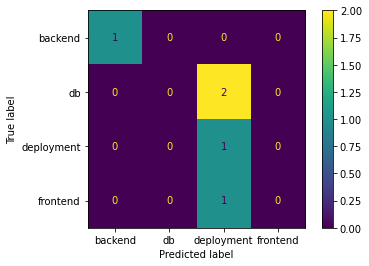

In [60]:
from sklearn import naive_bayes
from sklearn import tree
from sklearn.naive_bayes import MultinomialNB
model, test_result = classify(df, naive_bayes.MultinomialNB(), init_state)

In [61]:
test_result

,filename,data,#words,#lines,size (bytes),type,LSI k topics,LSI k+1 topics,MultinomialNB
0,db_mysql.log,"[mysql, note, entrypoint, entrypoint, script, ...",884,76,10336,db,3,3,deployment
1,deployment_elasticsearch.txt,"[sudo, kolla, set, configs, info, main, loadin...",161,25,2060,deployment,0,0,deployment
8,frontend_horizon.log,"[wed, jun, wsgi, error, pid, tid, usr, lib, py...",437,20,4197,frontend,0,4,deployment
13,backend_carts.log,"[info, bootstrap, main, annotationconfigapplic...",418,24,5342,backend,1,1,backend
15,db_elasticsearch.log,"[info, node, version, pid, build, oss, deb, cc...",506,40,6798,db,0,4,deployment


### T1.3 - Decision Tree Classifier

DecisionTreeClassifier
              precision    recall  f1-score   support

     backend       1.00      1.00      1.00         1
          db       1.00      0.50      0.67         2
  deployment       1.00      1.00      1.00         1
    frontend       0.50      1.00      0.67         1

    accuracy                           0.80         5
   macro avg       0.88      0.88      0.83         5
weighted avg       0.90      0.80      0.80         5

Accuracy: 0.8


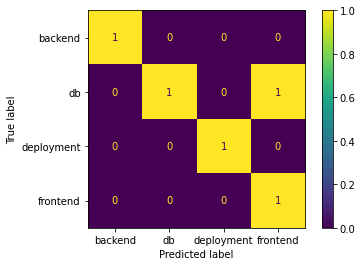

'tree.dot.png'

In [62]:
model, test_result = classify(df, tree.DecisionTreeClassifier(max_depth=10, random_state=init_state), init_state)
export_graphviz(model['clf'], out_file='tree.dot',  
                filled=True, rounded=True,
                special_characters=True,feature_names = model['tfidf'].get_feature_names(),class_names=list(set(df['type'])))

graphviz.Source.from_file('tree.dot')
graphviz.render('dot', 'png', 'tree.dot')

In [63]:
test_result

,filename,data,#words,#lines,size (bytes),type,LSI k topics,LSI k+1 topics,DecisionTreeClassifier
0,db_mysql.log,"[mysql, note, entrypoint, entrypoint, script, ...",884,76,10336,db,3,3,db
1,deployment_elasticsearch.txt,"[sudo, kolla, set, configs, info, main, loadin...",161,25,2060,deployment,0,0,deployment
8,frontend_horizon.log,"[wed, jun, wsgi, error, pid, tid, usr, lib, py...",437,20,4197,frontend,0,4,frontend
13,backend_carts.log,"[info, bootstrap, main, annotationconfigapplic...",418,24,5342,backend,1,1,backend
15,db_elasticsearch.log,"[info, node, version, pid, build, oss, deb, cc...",506,40,6798,db,0,4,frontend


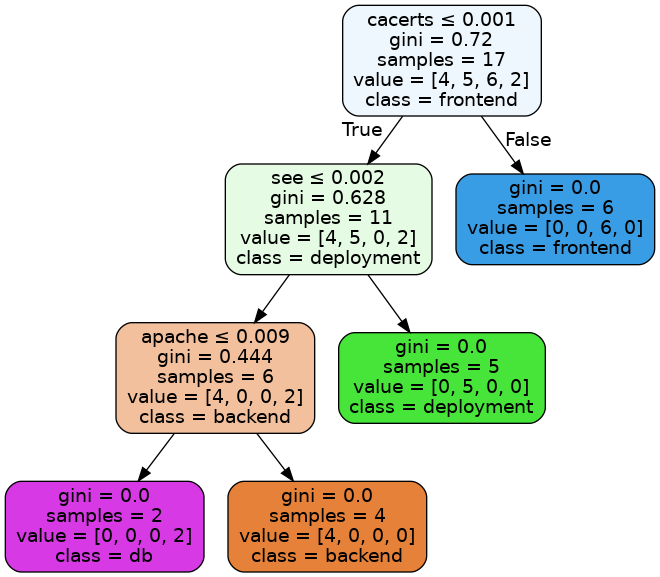

In [64]:
from IPython.display import Image
Image("tree.dot.png")

## T2 - Validation of Similarity Measures

4 test cases for 4 types

In [176]:
test_samples = ['backend_carts.log', 'db_carts-db.log', 'deployment_elasticsearch.txt', 'frontend_kibana.log']
test_case = 2 # index in test_samples
#requested_filename = test_samples[test_case]
requested_filename = 'db_mysql.log'

In [177]:
requested_file = df.loc[df['filename'] == requested_filename]
#requested_file = df.loc[df['filename'] == requested_filename]['data'].values[0]
#tokenized_requested_file = (requested_filename, requested_file.split(' '))
label = requested_file['type'].values[0]
classified_files = df.loc[df['type'] == label][df['filename'] != requested_filename]
#classified_files = df.loc[df['type'] == label]['data'].tolist()

In [178]:
len(classified_files.index)

6

### T2.1 - LSI-based Jaccard Similarity

In [179]:
ranking, keywords = lsi_jaccard_ranker(requested_file, classified_files)

-----------TOPIC - KEYWORDS--------------
[(0, [('create', 0.12422212137430301), ('initialize', 0.12422212137430301), ('version', 0.124222121374303), ('use', 0.12422212137430295), ('set', 0.12422212137430291), ('log', 0.12422212137430289), ('be', 0.12422212137430289), ('data', 0.12422212137430286), ('start', 0.12422212137430286), ('size', 0.12422212137430277), ('file', 0.12422212137430275), ('detect', 0.11472950152155025), ('path', 0.11472950152155016), ('enable', 0.11472950152155013), ('configuration', 0.11472950152155008), ('cache', 0.11472950152154993), ('database', 0.10777014322156163), ('connection', 0.1077701432215616), ('port', 0.10777014322156143), ('see', 0.10777014322156142)])]

-----------TOPIC - DOCUMENT--------------
[([(0, 6.893654449367824)], 'db_user-db.log'), ([(0, 7.278385684491931)], 'db_orders-db.log'), ([(0, 7.392327357589048)], 'db_carts-db.log'), ([(0, 3.243760208067525)], 'db_mariadb.log'), ([(0, 5.621869716017829)], 'db_elasticsearch.log'), ([(0, 12.01842889101

In [180]:
ranking

[('db_mariadb.log', 0.37524855405286656),
 ('db_user-db.log', 0.18672433657119825),
 ('db_orders-db.log', 0.18672433657119825),
 ('db_carts-db.log', 0.18522543765880173),
 ('db_mongo.log', 0.1583790879329611),
 ('db_elasticsearch.log', 0.14528781202810165)]

In [181]:
keywords

[('create', 0.12422212137430301),
 ('initialize', 0.12422212137430301),
 ('version', 0.124222121374303),
 ('use', 0.12422212137430295),
 ('set', 0.12422212137430291),
 ('log', 0.12422212137430289),
 ('be', 0.12422212137430289),
 ('data', 0.12422212137430286),
 ('start', 0.12422212137430286),
 ('size', 0.12422212137430277),
 ('file', 0.12422212137430275),
 ('detect', 0.11472950152155025),
 ('path', 0.11472950152155016),
 ('enable', 0.11472950152155013),
 ('configuration', 0.11472950152155008),
 ('cache', 0.11472950152154993),
 ('database', 0.10777014322156163),
 ('connection', 0.1077701432215616),
 ('port', 0.10777014322156143),
 ('see', 0.10777014322156142)]

### T2.2 - TF-IDF Cosine Similarity

In [182]:
tfidf_ranker(requested_file, classified_files)

[('db_mariadb.log', 0.5218730387198609),
 ('db_user-db.log', 0.036797053583060166),
 ('db_orders-db.log', 0.03364966795003639),
 ('db_carts-db.log', 0.03352977315487424),
 ('db_elasticsearch.log', 0.01987999438417126),
 ('db_mongo.log', 0.018741134554524794)]

### T2.3 - GloVe Cosine Similarity

In [183]:
ranking = glove_ranker(requested_file, classified_files)

mkdir -p build

$ build/vocab_count -min-count 1 -verbose 2 < corpus.txt > vocab.txt
$ build/cooccur -memory 4.0 -vocab-file vocab.txt -verbose 2 -window-size 15 < corpus.txt > cooccurrence.bin
$ build/shuffle -memory 4.0 -verbose 2 < cooccurrence.bin > cooccurrence.shuf.bin
$ build/glove -save-file vectors -threads 8 -input-file cooccurrence.shuf.bin -x-max 10 -iter 15 -vector-size 50 -binary 2 -vocab-file vocab.txt -verbose 2


BUILDING VOCABULARY
Processed 0 tokens.Processed 3621 tokens.
Counted 740 unique words.
Using vocabulary of size 740.

COUNTING COOCCURRENCES
window size: 15
context: symmetric
max product: 13752509
overflow length: 38028356
Reading vocab from file "vocab.txt"...loaded 740 words.
Building lookup table...table contains 547601 elements.
Processing token: 0Processed 3621 tokens.
Writing cooccurrences to disk.....2 files in total.
Merging cooccurrence files: processed 0 lines.0 lines.Merging cooccurrence files: processed 34004 lines.

Using random seed 1632255384
SHUFFLING COOCCURRENCES
array size: 255013683
Shuffling by chunks: processed 0 lines.processed 34004 lines.
Wrote 1 temporary file(s).
Merging temp files: processed 0 lines.34004 lines.Merging temp files: processed 34004 lines.

TRAINING MODEL
Read 34004 lines.
Initializing parameters...Using random seed 1632255384
done.
vector size: 50
vocab size: 740
x_max: 10.000000
alpha: 0.750000
09/21/21 - 10:16.24PM, iter: 001, cost: 0.0831

Loading Glove Model
Done. 741  words loaded!


In [184]:
ranking

[('db_mariadb.log', 0.9899760299821777),
 ('db_mongo.log', 0.24099970337711363),
 ('db_orders-db.log', 0.22778896105190238),
 ('db_carts-db.log', 0.22641329345604144),
 ('db_elasticsearch.log', 0.2144248712797574),
 ('db_user-db.log', 0.20364116574888858)]

## T3 - Hybrid approaches

In [185]:
request = df.loc[df['filename'] == requested_filename]

In [186]:
request

,filename,data,#words,#lines,size (bytes),type,LSI k topics,LSI k+1 topics
0,db_mysql.log,"[mysql, note, entrypoint, entrypoint, script, ...",884,76,10336,db,3,3


### T3.1 - LSI-based Classifier + LSI-based Jaccard Similarity Ranking

In [187]:
lsi_label = request['LSI k topics'].values[0]
k_topics = True
same_class = df.loc[df['LSI k topics'] == lsi_label][df['filename'] != requested_filename]
if request['LSI k topics'].values[0] != request['LSI k+1 topics'].values[0]:
    lsi_label = request['LSI k+1 topics'].values[0]
    k_topics = False
    same_class = df.loc[df['LSI k+1 topics'] == lsi_label][df['filename'] != requested_filename]

In [188]:
same_class

,filename,data,#words,#lines,size (bytes),type,LSI k topics,LSI k+1 topics
14,db_mariadb.log,"[warning, failed, to, load, slave, replication...",315,35,3004,db,3,3


In [189]:
ranking, keywords = lsi_jaccard_ranker(requested_file, same_class)

-----------TOPIC - KEYWORDS--------------
[(0, [('add', 0.10000000000000032), ('daemon', 0.1000000000000002), ('exit', 0.10000000000000017), ('aio', 0.10000000000000016), ('create', 0.10000000000000014), ('dump', 0.10000000000000014), ('ft', 0.10000000000000014), ('data', 0.1000000000000001), ('mutexes', 0.1000000000000001), ('gtid', 0.10000000000000009), ('lock', 0.10000000000000009), ('errno', 0.10000000000000009), ('log', 0.10000000000000007), ('ib', 0.10000000000000007), ('event', 0.10000000000000007), ('see', 0.10000000000000006), ('builtins', 0.10000000000000006), ('share', 0.10000000000000006), ('man', 0.10000000000000006), ('process', 0.10000000000000005)])]

-----------TOPIC - DOCUMENT--------------
[([(0, 9.999999999999984)], 'db_mariadb.log')]


In [190]:
ranking

[('db_mariadb.log', 0.3651508329581268)]

### T3.2 - LSI-based Classifier + TF-IDF Cosine Similarity

In [191]:
tfidf_ranker(requested_file, same_class)

[('db_mariadb.log', 0.5218730387198609)]

### T3.3 - LSI-based Classifier + GloVe Cosine Similarity

In [192]:
ranking = glove_ranker(requested_file, same_class)

mkdir -p build

$ build/vocab_count -min-count 1 -verbose 2 < corpus.txt > vocab.txt
$ build/cooccur -memory 4.0 -vocab-file vocab.txt -verbose 2 -window-size 15 < corpus.txt > cooccurrence.bin
$ build/shuffle -memory 4.0 -verbose 2 < cooccurrence.bin > cooccurrence.shuf.bin
$ build/glove -save-file vectors -threads 8 -input-file cooccurrence.shuf.bin -x-max 10 -iter 15 -vector-size 50 -binary 2 -vocab-file vocab.txt -verbose 2
Loading Glove Model
Done. 318  words loaded!


BUILDING VOCABULARY
Processed 0 tokens.Processed 1199 tokens.
Counted 317 unique words.
Using vocabulary of size 317.

COUNTING COOCCURRENCES
window size: 15
context: symmetric
max product: 13752509
overflow length: 38028356
Reading vocab from file "vocab.txt"...loaded 317 words.
Building lookup table...table contains 100490 elements.
Processing token: 0Processed 1199 tokens.
Writing cooccurrences to disk.....2 files in total.
Merging cooccurrence files: processed 0 lines.0 lines.Merging cooccurrence files: processed 13047 lines.

Using random seed 1632255385
SHUFFLING COOCCURRENCES
array size: 255013683
Shuffling by chunks: processed 0 lines.processed 13047 lines.
Wrote 1 temporary file(s).
Merging temp files: processed 0 lines.13047 lines.Merging temp files: processed 13047 lines.

TRAINING MODEL
Read 13047 lines.
Initializing parameters...Using random seed 1632255385
done.
vector size: 50
vocab size: 317
x_max: 10.000000
alpha: 0.750000
09/21/21 - 10:16.25PM, iter: 001, cost: 0.0654

In [193]:
ranking

[('db_mariadb.log', 0.9965471162539028)]

### T3.4 - Naive Bayes Classifier + LSI-based Jaccard Similarity

In [194]:
old_logs = df.loc[df['filename'] != requested_filename]

MultinomialNB
              precision    recall  f1-score   support

     backend       1.00      1.00      1.00         1
          db       0.00      0.00      0.00         0
  deployment       1.00      0.25      0.40         4

    accuracy                           0.40         5
   macro avg       0.67      0.42      0.47         5
weighted avg       1.00      0.40      0.52         5

Accuracy: 0.4


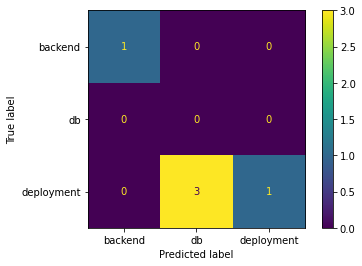

In [195]:
model, test_result = classify(old_logs, naive_bayes.MultinomialNB(), init_state)
prediction = model.predict(request['data'])[0]

In [196]:
prediction

'db'

In [197]:
same_class = df.loc[df['type'] == prediction][df['filename'] != requested_filename]

In [198]:
same_class

,filename,data,#words,#lines,size (bytes),type,LSI k topics,LSI k+1 topics
3,db_user-db.log,"[control, initandlisten, mongodb, starting, pi...",230,25,2788,db,2,2
5,db_orders-db.log,"[control, initandlisten, mongodb, starting, pi...",227,26,2914,db,2,2
6,db_carts-db.log,"[control, initandlisten, mongodb, starting, pi...",230,26,2915,db,2,2
14,db_mariadb.log,"[warning, failed, to, load, slave, replication...",315,35,3004,db,3,3
15,db_elasticsearch.log,"[info, node, version, pid, build, oss, deb, cc...",506,40,6798,db,0,4
20,db_mongo.log,"[mongo, date, control, id, ctx, main, msg, aut...",1229,64,17045,db,2,2


In [199]:
ranking, keywords = lsi_jaccard_ranker(requested_file, same_class)

-----------TOPIC - KEYWORDS--------------
[(0, [('be', 0.12422212137430366), ('size', 0.1242221213743032), ('file', 0.12422212137430302), ('version', 0.124222121374303), ('use', 0.12422212137430291), ('log', 0.12422212137430289), ('initialize', 0.12422212137430289), ('set', 0.12422212137430286), ('create', 0.1242221213743028), ('data', 0.1242221213743028), ('start', 0.12422212137430277), ('detect', 0.11472950152155058), ('enable', 0.11472950152155056), ('path', 0.11472950152155033), ('configuration', 0.1147295015215503), ('cache', 0.11472950152155004), ('port', 0.10777014322156143), ('connection', 0.10777014322156139), ('database', 0.10777014322156139), ('see', 0.10777014322156134)])]

-----------TOPIC - DOCUMENT--------------
[([(0, 6.893654449367826)], 'db_user-db.log'), ([(0, 7.278385684491934)], 'db_orders-db.log'), ([(0, 7.392327357589052)], 'db_carts-db.log'), ([(0, 3.2437602080675303)], 'db_mariadb.log'), ([(0, 5.621869716017838)], 'db_elasticsearch.log'), ([(0, 12.0184288910198

In [200]:
ranking

[('db_mariadb.log', 0.37524855405286656),
 ('db_user-db.log', 0.18672433657119827),
 ('db_orders-db.log', 0.18672433657119827),
 ('db_carts-db.log', 0.18522543765880176),
 ('db_mongo.log', 0.1583790879329611),
 ('db_elasticsearch.log', 0.14528781202810165)]

### T3.5 - Naive Bayes Classifier + TF-IDF Cosine Similarity

In [201]:
tfidf_ranker(requested_file, same_class)

[('db_mariadb.log', 0.5218730387198609),
 ('db_user-db.log', 0.036797053583060166),
 ('db_orders-db.log', 0.03364966795003639),
 ('db_carts-db.log', 0.03352977315487424),
 ('db_elasticsearch.log', 0.01987999438417126),
 ('db_mongo.log', 0.018741134554524794)]

### T3.6 - Naive Bayes Classifier + GloVe Cosine Similarity

In [202]:
ranking = glove_ranker(requested_file, same_class)

mkdir -p build

$ build/vocab_count -min-count 1 -verbose 2 < corpus.txt > vocab.txt
$ build/cooccur -memory 4.0 -vocab-file vocab.txt -verbose 2 -window-size 15 < corpus.txt > cooccurrence.bin
$ build/shuffle -memory 4.0 -verbose 2 < cooccurrence.bin > cooccurrence.shuf.bin
$ build/glove -save-file vectors -threads 8 -input-file cooccurrence.shuf.bin -x-max 10 -iter 15 -vector-size 50 -binary 2 -vocab-file vocab.txt -verbose 2


BUILDING VOCABULARY
Processed 0 tokens.Processed 3621 tokens.
Counted 740 unique words.
Using vocabulary of size 740.

COUNTING COOCCURRENCES
window size: 15
context: symmetric
max product: 13752509
overflow length: 38028356
Reading vocab from file "vocab.txt"...loaded 740 words.
Building lookup table...table contains 547601 elements.
Processing token: 0Processed 3621 tokens.
Writing cooccurrences to disk.....2 files in total.
Merging cooccurrence files: processed 0 lines.0 lines.Merging cooccurrence files: processed 34004 lines.

Using random seed 1632255385
SHUFFLING COOCCURRENCES
array size: 255013683
Shuffling by chunks: processed 0 lines.processed 34004 lines.
Wrote 1 temporary file(s).
Merging temp files: processed 0 lines.34004 lines.Merging temp files: processed 34004 lines.

TRAINING MODEL
Read 34004 lines.
Initializing parameters...Using random seed 1632255385
done.
vector size: 50
vocab size: 740
x_max: 10.000000
alpha: 0.750000
09/21/21 - 10:16.25PM, iter: 001, cost: 0.0822

Loading Glove Model
Done. 741  words loaded!


09/21/21 - 10:16.25PM, iter: 015, cost: 0.047252


In [203]:
ranking

[('db_mariadb.log', 0.9922741758085369),
 ('db_elasticsearch.log', 0.3712470969894581),
 ('db_orders-db.log', 0.2948835376851642),
 ('db_carts-db.log', 0.29225091206774945),
 ('db_user-db.log', 0.2643455147488547),
 ('db_mongo.log', 0.18386465149130715)]

### T3.47 - Decision Tree Classifier + LSI-based Jaccard Similarity

DecisionTreeClassifier
              precision    recall  f1-score   support

     backend       1.00      1.00      1.00         1
  deployment       1.00      1.00      1.00         4

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5

Accuracy: 1.0


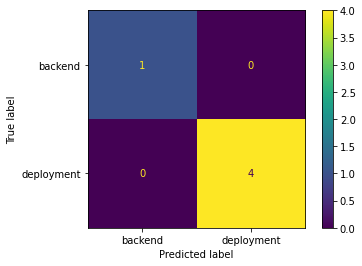

In [204]:
model, test_result = classify(old_logs, tree.DecisionTreeClassifier(max_depth=10), 42)
prediction = model.predict(request['data'])[0]

In [205]:
prediction

'frontend'

In [206]:
same_class = df.loc[df['type'] == prediction][df['filename'] != requested_filename]

In [207]:
same_class

,filename,data,#words,#lines,size (bytes),type,LSI k topics,LSI k+1 topics
7,frontend_kibana.log,"[type, log, timestamp, tags, info, plugins, se...",392,16,4660,frontend,0,4
8,frontend_horizon.log,"[wed, jun, wsgi, error, pid, tid, usr, lib, py...",437,20,4197,frontend,0,4
12,frontend_kibana-simple.log,"[type, log, timestamp, tags, info, plugins, se...",577,22,5832,frontend,1,4


In [208]:
ranking, keywords = lsi_jaccard_ranker(requested_file, same_class)

-----------TOPIC - KEYWORDS--------------
[(0, [('set', 0.10564561908324527), ('type', 0.10564561908324521), ('be', 0.10564561908324521), ('use', 0.10564561908324521), ('elasticsearch', 0.09997358238336482), ('savedobjects', 0.09997358238336478), ('vistypetimeseries', 0.09997358238336476), ('start', 0.09997358238336476), ('management', 0.09997358238336475), ('plugin', 0.09997358238336473), ('kibana', 0.09997358238336473), ('vistypexy', 0.09997358238336473), ('timestamp', 0.09997358238336473), ('visualization', 0.09997358238336473), ('system', 0.09997358238336473), ('inputcontrolvis', 0.09997358238336473), ('telemetrycollectionmanager', 0.09997358238336472), ('share', 0.09997358238336472), ('timelion', 0.09997358238336472), ('vistypetimelion', 0.09997358238336472)])]

-----------TOPIC - DOCUMENT--------------
[([(0, 5.997324850429008)], 'frontend_kibana.log'), ([(0, 1.0170859208091625)], 'frontend_horizon.log'), ([(0, 11.929520209849825)], 'frontend_kibana-simple.log')]


In [209]:
ranking

[('frontend_kibana-simple.log', 0.11066295377092218),
 ('frontend_kibana.log', 0.0942202834628266),
 ('frontend_horizon.log', 0.053711413670753216)]

### T3.8 - Decision Tree Classifier + TF-IDF Cosine Similarity

In [210]:
tfidf_ranker(requested_file, same_class)

[('frontend_kibana-simple.log', 0.04910396421057969),
 ('frontend_horizon.log', 0.027875215855510886),
 ('frontend_kibana.log', 0.024302204003829854)]

### T3.9 - Decision Tree Classifier + GloVe Cosine Similarity

In [211]:
ranking = glove_ranker(requested_file, same_class)

mkdir -p build

$ build/vocab_count -min-count 1 -verbose 2 < corpus.txt > vocab.txt
$ build/cooccur -memory 4.0 -vocab-file vocab.txt -verbose 2 -window-size 15 < corpus.txt > cooccurrence.bin
$ build/shuffle -memory 4.0 -verbose 2 < cooccurrence.bin > cooccurrence.shuf.bin
$ build/glove -save-file vectors -threads 8 -input-file cooccurrence.shuf.bin -x-max 10 -iter 15 -vector-size 50 -binary 2 -vocab-file vocab.txt -verbose 2
Loading Glove Model
Done. 534  words loaded!


BUILDING VOCABULARY
Processed 0 tokens.Processed 2290 tokens.
Counted 533 unique words.
Using vocabulary of size 533.

COUNTING COOCCURRENCES
window size: 15
context: symmetric
max product: 13752509
overflow length: 38028356
Reading vocab from file "vocab.txt"...loaded 533 words.
Building lookup table...table contains 284090 elements.
Processing token: 0Processed 2290 tokens.
Writing cooccurrences to disk.....2 files in total.
Merging cooccurrence files: processed 0 lines.0 lines.Merging cooccurrence files: processed 23400 lines.

Using random seed 1632255386
SHUFFLING COOCCURRENCES
array size: 255013683
Shuffling by chunks: processed 0 lines.processed 23400 lines.
Wrote 1 temporary file(s).
Merging temp files: processed 0 lines.23400 lines.Merging temp files: processed 23400 lines.

TRAINING MODEL
Read 23400 lines.
Initializing parameters...Using random seed 1632255386
done.
vector size: 50
vocab size: 533
x_max: 10.000000
alpha: 0.750000
09/21/21 - 10:16.26PM, iter: 001, cost: 0.0793

In [212]:
ranking

[('frontend_horizon.log', 0.5507961320461574),
 ('frontend_kibana-simple.log', 0.11211885798673316),
 ('frontend_kibana.log', 0.08381677361856621)]